# Packages Used

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
import xgboost
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

# Data Pre-processing

In [2]:
# Reading the forest fire data
df = pd.read_csv('forestfires.csv')

In [3]:
# Manually creating label encoding dictionary and mapping to the categorical variables
month_map = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,
            'sep':9,'oct':10,'nov':11,'dec':12}
day_map = {'sun':1,'mon':2,'tue':3,'wed':4,'thu':5,'fri':6,'sat':7} 

df['month'] = df['month'].replace(month_map)
df['day'] = df['day'].replace(day_map)

Text(0.5, 1, 'Correlation Heatmap')

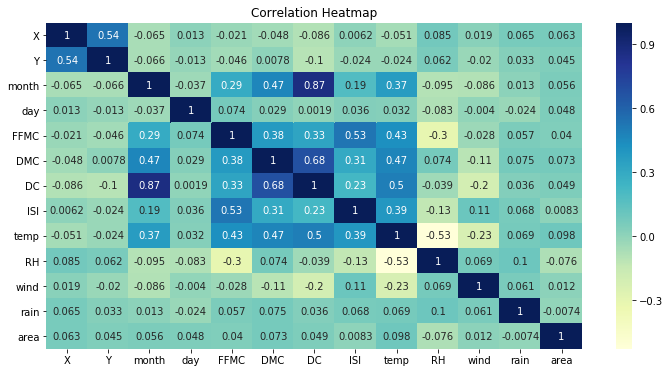

In [4]:
# plotting correlation heat map of the dataframe
corr = df.corr()
plt.figure(figsize=(12,6))
sns.heatmap(corr, annot=True,cmap="YlGnBu",
        xticklabels=corr.columns,
        yticklabels=corr.columns).set_title('Correlation Heatmap')

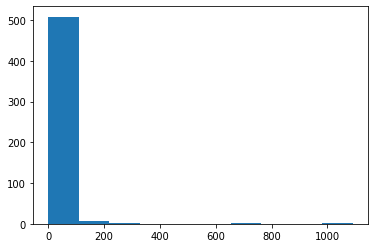

In [5]:
# plotting the histogram of the target variable feature - area
plt.hist(df['area'])
plt.show()

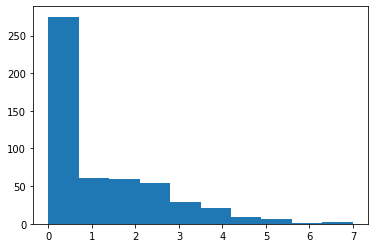

In [6]:
# plotting the histogram of the target variable feature - area after 
# log tranformation was applied
plt.hist(df['area'].apply(lambda x: np.log(x + 1)))
plt.show()

In [7]:
# Splitting the train and test for the use of hyper-paramter tuning of the models
X = df.drop(['area'], axis = 1)
y = df['area']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=0)

In [8]:
# Applying log transformation on the area column
y_train_log = np.log(y_train + 1)
y_test_log = np.log(y_test + 1)
y_log = np.log(y + 1)

# 10 Fold Cross-Validation Function

In [17]:
##########################################################################
# This function inputs:
# reg - regression model
# x_trn - independent variables
# y_trn - target variable
# y_log_trn - log transformed target varaible
# k - k folds
# scale - Given as True if feature scaling is required to be performed on train and test folds
# pca - Given as True if pca has to be performed on train and test folds
############################################################################
# Function Output:
# Returns the average of k fold iterations for the following evaluation metrics:
# MSE, NLL, RMSE, MAD for test fold data
# RMSE for train fold data
###########################################################################
def k_fold_cv(reg, x_trn,y_trn,y_log_trn,k, scale = False, pca = False):
    train_error_rmse = [] # assigns lists to capture the evaluation metrics of k fold validation
    test_error_rmse = []
    train_error_mad = []
    test_error_mad = []
    test_error_mse = []
    nll_list = []
    cv = KFold(n_splits=k, random_state=42, shuffle=True) # Random state is assigned to keep the split
    for train_index, test_index in cv.split(x_trn):       # consistent for all model 
        X_train, X_test, y_train, y_test,y_log_train = x_trn.iloc[train_index,], x_trn.iloc[test_index,],  \
                          y_trn.iloc[train_index,], y_trn.iloc[test_index,],y_log_trn.iloc[train_index,]

        if pca: # feature scaling and pca is applied
            scale = StandardScaler()
            scale.fit(X_train)
            X_train = scale.transform(X_train)
            X_test = scale.transform(X_test)
            pca = PCA(0.8) # overall variance of pca to capture
            pca.fit(X_train)

            X_train = pca.transform(X_train)
            X_test = pca.transform(X_test)
        elif scale: # feature scaling is applied
            scale = StandardScaler()
            X_train = pd.DataFrame(scale.fit_transform(X_train))
            X_test = pd.DataFrame(scale.transform(X_test))
            
        reg.fit(X_train, y_log_train) # Fitting the model with k-1 fold train data
        
        pred_train = reg.predict(X_train) # predicitng the output of k-1 fold train data
        pred_test = reg.predict(X_test) # predicting the output of 1 fold test data

        # Applying inverse of log tranformation on predicted value 
        # to evaluate the error between actual and predicted value
        pred_train = 10**pred_train-1
        pred_test = 10**pred_test-1
        
        pred_train[pred_train < 0] = 0 # after inverse of log, some predicted values tend to be negative
        pred_test[pred_test < 0] = 0 # they are assigned to be 0 since burned area cannot be negative
        
        ######## Calculating negative log likelihood
        var = np.var(pred_test)
        mean = np.mean(pred_test)
        sum_error = 0
        for i in range(0,len(pred_test)):
            sum_error = sum_error + (y_test.iloc[i] - pred_test[i])**2 # sum of (actual - pred)^2
            
        nll = (len(pred_test)*0.5*np.log(2*3.14*var)) + (sum_error/(2*var))
        nll_list.append(nll)
        ######## calculating RMSE of train and test data
        train_error_rmse.append(sqrt(mean_squared_error(y_train, pred_train)))
        test_error_rmse.append(sqrt(mean_squared_error(y_test, pred_test)))
        ######## calculating MAD of test data
        test_error_mad.append(mean_absolute_error(y_test, pred_test))
        ######## calculating MSE of test data
        test_error_mse.append(mean_squared_error(y_test, pred_test))
    return np.average(train_error_rmse), np.average(test_error_rmse), np.average(test_error_mad),\
                np.average(test_error_mse), np.average(nll_list)
            

# Support Vector Machine

In [20]:
kernels = ['linear','rbf','poly']
for ker in kernels:
    start_time = time.time()
    regressor = SVR(kernel=ker, degree = 2)
    train_error_rmse, test_error_rmse,test_error_mad,test_error_mse,nll = k_fold_cv(regressor, X,y,y_log,10,scale=True)
    
    print("MSE of SVR",ker,"kernel test data:",test_error_mse)
    print("NLL of SVR",ker,"kernel test data:",nll)
    print("RMSE of SVR",ker,"kernel Test data:",test_error_rmse)
    print("MAD of SVR",ker,"kernel Test data:",test_error_mad)
    elapsed_time = time.time()-start_time
    print("Run time:"+time.strftime("%H%M%S",time.gmtime(elapsed_time)))


MSE of SVR linear kernel test data: 4727.579648282326
NLL of SVR linear kernel test data: 644.1491869368161
RMSE of SVR linear kernel Test data: 53.521626924360305
MAD of SVR linear kernel Test data: 16.885132488272088
Run time:000000
MSE of SVR rbf kernel test data: 5336.027781821719
NLL of SVR rbf kernel test data: 314.3938633416286
RMSE of SVR rbf kernel Test data: 57.045649779937435
MAD of SVR rbf kernel Test data: 18.519718821226586
Run time:000000
MSE of SVR poly kernel test data: 6.4835503326329486e+78
NLL of SVR poly kernel test data: 786.2378251784578
RMSE of SVR poly kernel Test data: 8.052049635113379e+38
MAD of SVR poly kernel Test data: 1.116618378153169e+38
Run time:000000


# Linear Regression

In [379]:
start_time = time.time()
regressor = linear_model.LinearRegression() 
train_error_rmse, test_error_rmse,test_error_mad,test_error_mse,nll = k_fold_cv(regressor, X,y,y_log,10,pca=True)

print("MSE of linear regression test data:",test_error_mse) 
print("NLL of linear regression test data:",nll) 
print("RMSE of linear regression Test data:",test_error_rmse)
print("MAD of linear regression Test data:",test_error_mad)
elapsed_time = time.time()-start_time
print("Run time:"+time.strftime("%H%M%S",time.gmtime(elapsed_time)))

MSE of linear regression test data: 4428.921431301083
NLL of linear regression test data: 4418.912057373888
RMSE of linear regression Test data: 51.915009304269766
MAD of linear regression Test data: 21.417244180686122
Run time:000000


# Polynomial Regression

In [374]:
start_time = time.time()
regressor = linear_model.LinearRegression() 
polynomial_features= PolynomialFeatures(degree=2)
x_poly = pd.DataFrame(polynomial_features.fit_transform(X))

train_error_rmse, test_error_rmse,test_error_mad,test_error_mse,nll = k_fold_cv(regressor, x_poly,y,y_log,10,scale=True)

print("MSE of poylnomial regression test data:",test_error_mse)
print("NLL of poylnomial regression test data:",nll)
print("RMSE of poylnomial regression Test data:",test_error_rmse)
print("MAD of poylnomial regression Test data:",test_error_mad)
elapsed_time = time.time()-start_time
print("Run time:"+time.strftime("%H%M%S",time.gmtime(elapsed_time)))

MSE of poylnomial regression test data: 1.784644001038936e+181
NLL of poylnomial regression test data: 1470.0038376830628
RMSE of poylnomial regression Test data: 1.3359056856825394e+90
MAD of poylnomial regression Test data: 1.8525678649662597e+89
Run time:000000


# Hyper-parameter Tuning for Random Forest

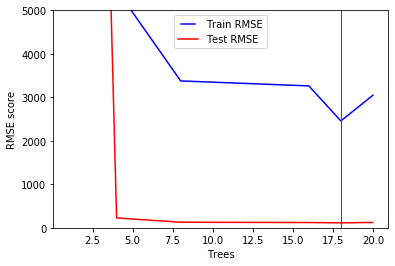

In [300]:
# to find the n_estimators
n_estimators = [1, 2, 4, 8, 16,18,20]
train_results = []
test_results = []
for estimator in n_estimators:
    # Fitting the model for each estimator
    model = RandomForestRegressor(n_estimators=estimator, random_state = 0)
    model.fit(X_train,  y_train_log)
    y_pred_train = model.predict(X_train)
    y_pred_train = 10**y_pred_train-1 # inverse of log tranformation for train predicted value
    train_results.append(sqrt(mean_squared_error(y_train, y_pred_train)))
    y_pred_test = model.predict(X_test)
    y_pred_test = 10**y_pred_test-1 # inverse of log tranformation for test predicted value
    test_results.append(sqrt(mean_squared_error(y_test, y_pred_test)))
# plotting the error of train and test data for different values of the parameter
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train RMSE")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test RMSE")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylim(0,5000)
plt.axvline(18, color = 'green', linewidth = 1)
plt.ylabel('RMSE score')
plt.xlabel('Trees')
plt.show()

C:\Users\renil934\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\renil934\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\renil934\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\renil934\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\renil934\Anaconda3\lib\site-packages\sklearn\ensemble\f

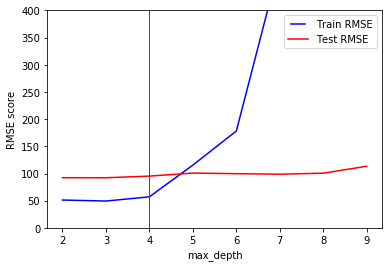

In [302]:
# to find the max_depth
max_depths = [2,3,4,5,6,7,8,9]
train_results = []
test_results = []
for max_depth in max_depths:
    model = RandomForestRegressor(max_depth=max_depth, random_state = 0)
    model.fit(X_train,  y_train_log)
    y_pred_train = model.predict(X_train)
    y_pred_train = 10**y_pred_train-1
    train_results.append(sqrt(mean_squared_error(y_train, y_pred_train)))
    y_pred_test = model.predict(X_test)
    y_pred_test = 10**y_pred_test-1
    test_results.append(sqrt(mean_squared_error(y_test, y_pred_test)))
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train RMSE")
line2, = plt.plot(max_depths, test_results, 'r', label="Test RMSE")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.axvline(4, color = 'green', linewidth = 1)
plt.ylim(0,400)
plt.ylabel('RMSE score')
plt.xlabel('max_depth')
plt.show()

C:\Users\renil934\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\renil934\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\renil934\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\renil934\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\renil934\Anaconda3\lib\site-packages\sklearn\ensemble\f

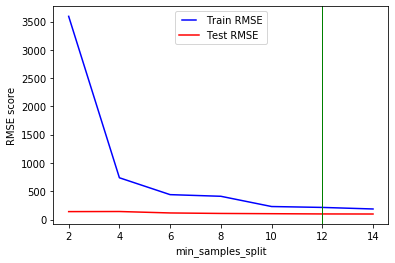

In [303]:
# to find min_sample_split
min_samples_splits = [2,4,6,8,10,12,14]
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    model = RandomForestRegressor(min_samples_split=min_samples_split,random_state = 0)
    model.fit(X_train,  y_train_log)
    y_pred_train = model.predict(X_train)
    y_pred_train = 10**y_pred_train-1
    train_results.append(sqrt(mean_squared_error(y_train, y_pred_train)))
    y_pred_test = model.predict(X_test)
    y_pred_test = 10**y_pred_test-1
    test_results.append(sqrt(mean_squared_error(y_test, y_pred_test)))
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train RMSE")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test RMSE")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.axvline(12, color = 'green', linewidth = 1)
plt.ylabel('RMSE score')
plt.xlabel('min_samples_split')
plt.show() 

C:\Users\renil934\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\renil934\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\renil934\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\renil934\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\renil934\Anaconda3\lib\site-packages\sklearn\ensemble\f

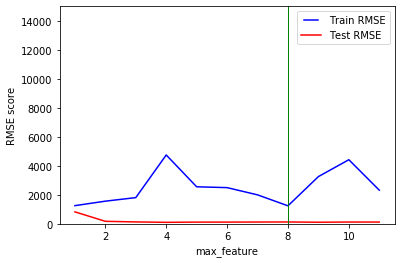

In [304]:
# to find the max_feature
max_features = list(range(1,X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    model = RandomForestRegressor(max_features=max_feature, random_state = 0)
    model.fit(X_train,  y_train_log)
    y_pred_train = model.predict(X_train)
    y_pred_train = 10**y_pred_train-1
    train_results.append(sqrt(mean_squared_error(y_train, y_pred_train)))
    y_pred_test = model.predict(X_test)
    y_pred_test = 10**y_pred_test-1
    test_results.append(sqrt(mean_squared_error(y_test, y_pred_test)))
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Train RMSE")
line2, = plt.plot(max_features, test_results, 'r', label="Test RMSE")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylim(0,15000)
plt.axvline(8, color = 'green', linewidth = 1)
plt.ylabel('RMSE score')
plt.xlabel('max_feature')
plt.show()

# Random Forest Regression

In [410]:
start_time = time.time()
regressor = RandomForestRegressor(max_features=8,max_depth=4,n_estimators=18, random_state = 0,min_samples_split=12)
train_error_rmse, test_error_rmse,test_error_mad,test_error_mse,nll = k_fold_cv(regressor, X,y,y_log,10)
print("MSE of random forest test data:",test_error_mse)
print("NLL of random forest test data:",nll)
print("RMSE of random forest Test data:",test_error_rmse)
print("MAD of random forest Test data:",test_error_mad)
elapsed_time = time.time()-start_time
print("Run time:"+time.strftime("%H%M%S",time.gmtime(elapsed_time)))

MSE of random forest test data: 4557.291694721544
NLL of random forest test data: 675.3723261758893
RMSE of random forest Test data: 54.83368454901519
MAD of random forest Test data: 23.250685631441463
Run time:000000


# Hyper-parameter tuning for XGBoost

C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:23:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:23:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:23:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:23:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


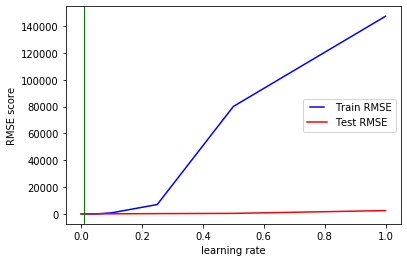

In [307]:
# to find the learning rate of the model
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01,0.001,0.0001]
train_results = []
test_results = []
for eta in learning_rates:
    model = xgboost.XGBRegressor(learning_rate=eta)
    model.fit(X_train,  y_train_log)
    y_pred_train = model.predict(X_train)
    y_pred_train = 10**y_pred_train-1
    train_results.append(sqrt(mean_squared_error(y_train, y_pred_train)))
    y_pred_test = model.predict(X_test)
    y_pred_test = 10**y_pred_test-1
    test_results.append(sqrt(mean_squared_error(y_test, y_pred_test)))
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label="Train RMSE")
line2, = plt.plot(learning_rates, test_results, 'r', label="Test RMSE")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.axvline(0.01, color = 'green', linewidth = 1)
plt.ylabel('RMSE score')
plt.xlabel('learning rate')
plt.show()

C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Us

[11:23:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:23:54] WARNI

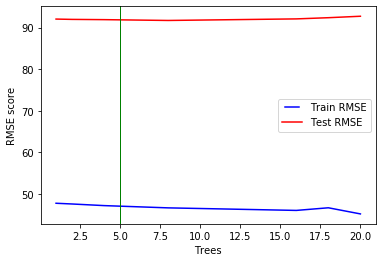

In [308]:
# to find the n_estimators
n_estimators = [1, 2, 4, 8, 16,18,20]
train_results = []
test_results = []
for estimator in n_estimators:
    model = xgboost.XGBRegressor(n_estimators=estimator)
    model.fit(X_train,  y_train_log)
    y_pred_train = model.predict(X_train)
    y_pred_train = 10**y_pred_train-1
    train_results.append(sqrt(mean_squared_error(y_train, y_pred_train)))
    y_pred_test = model.predict(X_test)
    y_pred_test = 10**y_pred_test-1
    test_results.append(sqrt(mean_squared_error(y_test, y_pred_test)))
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train RMSE")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test RMSE")
plt.axvline(5, color = 'green', linewidth = 1)
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('RMSE score')
plt.xlabel('Trees')
plt.show()

C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:25:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:25:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:25:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:25:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:25:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:25:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:25:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:25:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


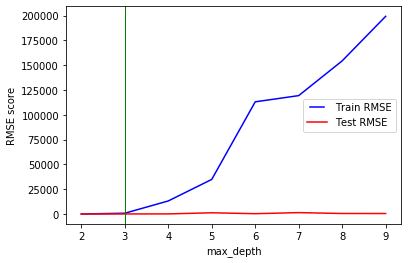

In [309]:
# to find the maximum depth of the model
max_depths = [2,3,4,5,6,7,8,9]
train_results = []
test_results = []
for max_depth in max_depths:
    model = xgboost.XGBRegressor(max_depth=max_depth)
    model.fit(X_train,  y_train_log)
    y_pred_train = model.predict(X_train)
    y_pred_train = 10**y_pred_train-1
    train_results.append(sqrt(mean_squared_error(y_train, y_pred_train)))
    y_pred_test = model.predict(X_test)
    y_pred_test = 10**y_pred_test-1
    test_results.append(sqrt(mean_squared_error(y_test, y_pred_test)))
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train RMSE")
line2, = plt.plot(max_depths, test_results, 'r', label="Test RMSE")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.axvline(3, color = 'green', linewidth = 1)
plt.ylabel('RMSE score')
plt.xlabel('max_depth')
plt.show()

C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:25:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:25:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:25:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[11:25:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:25:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


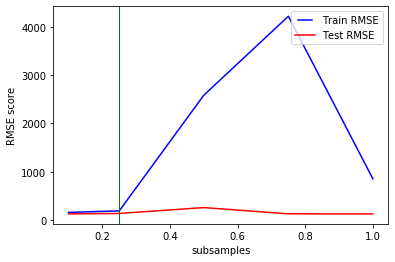

In [310]:
# to find the subsample of the models
subsamples = [0.1,0.25,0.5,0.75,1]
train_results = []
test_results = []
for subsample in subsamples:
    model = xgboost.XGBRegressor(subsample=subsample)
    model.fit(X_train,  y_train_log)
    y_pred_train = model.predict(X_train)
    y_pred_train = 10**y_pred_train-1
    train_results.append(sqrt(mean_squared_error(y_train, y_pred_train)))
    y_pred_test = model.predict(X_test)
    y_pred_test = 10**y_pred_test-1
    test_results.append(sqrt(mean_squared_error(y_test, y_pred_test)))
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(subsamples, train_results, 'b', label="Train RMSE")
line2, = plt.plot(subsamples, test_results, 'r', label="Test RMSE")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.axvline(0.25, color = 'green', linewidth = 1)
plt.ylabel('RMSE score')
plt.xlabel('subsamples')
plt.show()

# XGBoost Tree Regression Model

In [400]:
start_time = time.time()

regressor = xgboost.XGBRegressor(n_estimators=3, learning_rate=0.001, max_depth=3,subsample=0.25)
train_error_rmse, test_error_rmse,test_error_mad,test_error_mse,nll = k_fold_cv(regressor, X,y,y_log,10)

print("MSE of XGBoost test data:",test_error_mse)  
print("NLL of XGBoost test data:",nll)  
print("RMSE of XGBoost Test data:",test_error_rmse)
print("MAD of XGBoost Test data:",test_error_mad)
elapsed_time = time.time()-start_time
print("Run time:"+time.strftime("%H%M%S",time.gmtime(elapsed_time)))

[16:28:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:26] WARNI

C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Us

# XGBoost Linear Gradient Boosting Model

In [401]:
start_time = time.time()

regressor = xgboost.XGBRegressor(booster = 'gblinear')
train_error_rmse, test_error_rmse,test_error_mad,test_error_mse,nll = k_fold_cv(regressor, X,y,y_log,10)

print("MSE of XGBoost gblinear test data:",test_error_mse)
print("NLL of XGBoost gblinear test data:",nll)
print("RMSE of XGBoost gblinear Test data:",test_error_rmse)
print("MAD of XGBoost gblinear Test data:",test_error_mad)

elapsed_time = time.time()-start_time
print("Run time:"+time.strftime("%H%M%S",time.gmtime(elapsed_time)))

C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:28:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:28:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:28:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE of XGBoost gblinear test data: 4006.7442689268246
NLL of XGBoost gblinear test data: 5085.154343751
RMSE of XGBoost gblinear Test data: 46.45419051716742
MAD of XGBoost gblinear Test data: 18.649363506903295
Run time:000000


C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\renil934\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


# K Nearest Neighbors

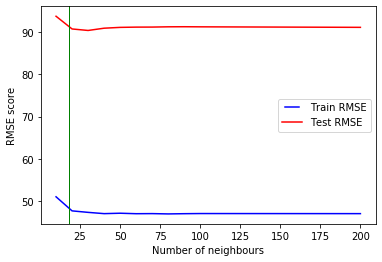

In [320]:
# to find the best number of neighbors for the model
n_estimators = [10,20,30,40,50,60,70,80,90,100,200]
train_results = []
test_results = []
for estimator in n_estimators:
    model = KNeighborsRegressor(n_neighbors=estimator)
    model.fit(X_train,  y_train_log)
    y_pred_train = model.predict(X_train)
    y_pred_train = 10**y_pred_train-1
    train_results.append(sqrt(mean_squared_error(y_train, y_pred_train)))
    y_pred_test = model.predict(X_test)
    y_pred_test = 10**y_pred_test-1
    test_results.append(sqrt(mean_squared_error(y_test, y_pred_test)))
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label="Train RMSE")
line2, = plt.plot(n_estimators, test_results, 'r', label="Test RMSE")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
#plt.ylim(0,60)
plt.axvline(18, color = 'green', linewidth = 1)
plt.ylabel('RMSE score')
plt.xlabel('Number of neighbours')
plt.show()

In [403]:
start_time = time.time()

regressor= KNeighborsRegressor(n_neighbors= 200)
train_error_rmse, test_error_rmse,test_error_mad,test_error_mse,nll = k_fold_cv(regressor, X,y,y_log,10,scale=True)

print("MSE of KNN test data:",test_error_mse)
print("NLL of KNN test data:",nll)
print("RMSE of KNN Test data:",test_error_rmse)
print("MAD of KNN Test data:",test_error_mad)

elapsed_time = time.time()-start_time
print("Run time:"+time.strftime("%H%M%S",time.gmtime(elapsed_time)))

MSE of KNN test data: 4028.0357083323674
NLL of KNN test data: 20688.015731362575
RMSE of KNN Test data: 46.22604167454104
MAD of KNN Test data: 18.083238882706684
Run time:000000
